<a href="https://colab.research.google.com/github/thimotyb/real-world-machine-learning/blob/python3/Forest%2C_Features_and_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimostrazione di valutazione dell'importanza delle feature selezionate nella foresta
## Confronto tra classificazione ad albero singolo, random forest e LightGBM


Import SciKit Tree Library and LightGBM Library

In [0]:
from sklearn import tree
import pandas
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb # Microsoft lightGBM install with: conda install -c conda-forge lightgbm

My functions to do OHE and do feature engineering on Titanic

In [0]:
def cat_to_num(data):
    categories = np.unique(data)
    features = {}
    for cat in categories:
        binary = (data == cat)
        features["%s=%s" % (data.name, cat)] = binary.astype("int")
    return pandas.DataFrame(features)
    
def prepare_data(data):
    """Takes a dataframe of raw data and returns ML model features
    """
    
    # Initially, we build a model only on the available numerical values
    features = data.drop(["PassengerId", "Survived", "Fare", "Name", "Sex", "Ticket", "Cabin", "Embarked"], axis=1)
    
    # Setting missing age values to -1
    features["Age"] = data["Age"].fillna(-1)
    
    # Adding the sqrt of the fare feature
    features["sqrt_Fare"] = np.sqrt(data["Fare"])
    
    # Adding gender categorical value
    features = features.join( cat_to_num(data['Sex']) )
    
    # Adding Embarked categorical value
    features = features.join( cat_to_num(data['Embarked'].fillna("")) )
    
    return features


Load, split, prepare data

In [0]:
data = pandas.read_csv("https://raw.githubusercontent.com/thimotyb/real-world-machine-learning/master/data/titanic.csv")
data_train = data[:int(0.8*len(data))]
data_test = data[int(0.8*len(data)):]
features = prepare_data(data_train)

In [5]:
features

Pclass   Age  SibSp  Parch  ...  Embarked=  Embarked=C  Embarked=Q  Embarked=S
0         3  22.0      1      0  ...          0           0           0           1
1         1  38.0      1      0  ...          0           1           0           0
2         3  26.0      0      0  ...          0           0           0           1
3         1  35.0      1      0  ...          0           0           0           1
4         3  35.0      0      0  ...          0           0           0           1
..      ...   ...    ...    ...  ...        ...         ...         ...         ...
707       1  42.0      0      0  ...          0           0           0           1
708       1  22.0      0      0  ...          0           0           0           1
709       3  -1.0      1      1  ...          0           1           0           0
710       1  24.0      0      0  ...          0           1           0           0
711       1  -1.0      0      0  ...          0           0           0           1

[712 rows x 11 columns]

## First Model: Using a Single Tree Classifier

In [6]:
model = tree.DecisionTreeClassifier(max_depth = 4)
model.fit(features, data_train["Survived"])
print(model.score(prepare_data(data_train), data_train["Survived"]))
model.score(prepare_data(data_test), data_test["Survived"])

0.8117977528089888


0.8212290502793296

## Second Model: Using a Random Forest

In [7]:
from sklearn import ensemble # RF is an ensemble category of model
forest = ensemble.RandomForestClassifier(n_estimators=5000, bootstrap=True, max_features=0.5)
forest.fit(features, data_train["Survived"])
print(forest.score(prepare_data(data_train), data_train["Survived"]))
forest.score(prepare_data(data_test), data_test["Survived"])

0.9817415730337079


0.8324022346368715

Si possono anche richiedere le predizioni in formato probabilistico, per settare la soglia di conversione del falso/vero positivo

In [8]:
forest_predict_proba=forest.predict_proba(prepare_data(data_test))
forest_predict_proba[:20]

array([[0.83476   , 0.16524   ],
       [0.34      , 0.66      ],
       [0.91110762, 0.08889238],
       [0.99424238, 0.00575762],
       [0.0056    , 0.9944    ],
       [0.25640683, 0.74359317],
       [0.96616   , 0.03384   ],
       [0.78950889, 0.21049111],
       [0.0079    , 0.9921    ],
       [0.95988333, 0.04011667],
       [0.33238619, 0.66761381],
       [0.91129429, 0.08870571],
       [0.6422    , 0.3578    ],
       [0.99527   , 0.00473   ],
       [0.251     , 0.749     ],
       [0.04021999, 0.95978001],
       [0.76027   , 0.23973   ],
       [0.3667    , 0.6333    ],
       [0.0068    , 0.9932    ],
       [0.46171667, 0.53828333]])

Feature importance in the Random Forest

In [0]:
# Elenca e visualizza il ranking delle feature usate nelal foresta
def show_features(forest, X, y):
  importances = forest.feature_importances_

  # Calcola deviazione standard per plottare errore
  std = np.std([tree.feature_importances_ for tree in forest.estimators_],
              axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. feature %s (%f)" % (indices[f], features.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()
  

Feature ranking:
4. feature sqrt_Fare (0.263193)
1. feature Age (0.234919)
6. feature Sex=male (0.146948)
5. feature Sex=female (0.143309)
0. feature Pclass (0.086669)
2. feature SibSp (0.048321)
3. feature Parch (0.037835)
10. feature Embarked=S (0.016369)
8. feature Embarked=C (0.013482)
9. feature Embarked=Q (0.008946)
7. feature Embarked= (0.000010)


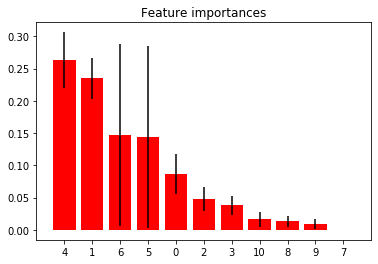

In [10]:
show_features(forest, features, data_train["Survived"])

Mostra gli Stimatori che sono stati usati per comporre la foresta

In [11]:
len(forest.estimators_) # Questo coincide con il numero di stimatori prodotti per popolare la foresta

5000

## Classificazione con una foresta più grande

In [12]:
extraforest = ensemble.ExtraTreesClassifier(n_estimators=100, bootstrap=True)
extraforest.fit(features, data_train["Survived"])
print(extraforest.score(prepare_data(data_train), data_train["Survived"]))
extraforest.score(prepare_data(data_test), data_test["Survived"])

0.9817415730337079


0.8156424581005587

Feature ranking:
4. feature sqrt_Fare (0.237113)
1. feature Age (0.226579)
5. feature Sex=female (0.173781)
6. feature Sex=male (0.121105)
0. feature Pclass (0.098642)
2. feature SibSp (0.055545)
3. feature Parch (0.051825)
10. feature Embarked=S (0.014421)
8. feature Embarked=C (0.011929)
9. feature Embarked=Q (0.008937)
7. feature Embarked= (0.000124)


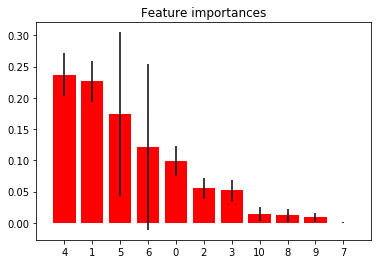

In [13]:
show_features(extraforest, features, data_train["Survived"])

## Classificazione con LightGBM

In [0]:
d_train = lgb.Dataset(features, label=data_train["Survived"])
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [0]:
#Prediction
y_pred=clf.predict(prepare_data(data_test))
pred_proba=clf.predict(prepare_data(data_test))
#convert into binary values

threshold = .45   # setting threshold

for i in range(0,len(y_pred)):
    if y_pred[i]>=threshold:       
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [16]:
data_test["Survived"]
y_pred

array([0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0.])

By definition a confusion matrix  is such that Ci,j is equal to the number of observations known to be in group i but predicted to be in group j.

Thus in binary classification, the count of true negatives is C0,0 , false negatives is C1,0, true positives is C1,1 and false positives is C0,1.

In [0]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data_test["Survived"], y_pred)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,data_test["Survived"])

In [18]:
print("Confusion Matrix:")
print(cm)
print("Model Accuracy: {0}".format(accuracy))

Confusion Matrix:
[[113   2]
 [ 31  33]]
Model Accuracy: 0.8156424581005587


## SHAP Explainer per interpretare i dati dell'ensemble LightGBM

[link text](https://github.com/slundberg/shap)

In [19]:
!pip install --upgrade shap
import shap

     |████████████████████████████████| 266kB 6.8MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376815 sha256=c2ac10eba1c18dbd44109670deb25ce8d3012e0d7dc12b77075392ca0f3b4d4b
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [20]:
explainer = shap.TreeExplainer(clf)
prepared_test = prepare_data(data_test)
shap_values = explainer.shap_values(prepared_test)

/usr/local/lib/python3.6/dist-packages/shap/explainers/tree.py:194: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


## Visualize a single prediction


In [22]:
# print the JS visualization code to the notebook
shap.initjs()
observation = 18 # Plotta il diagramma di forza dell'osservazione 0 del data set di training
print("Name: {0}".format(data_test.loc[data_test.index[observation],'Name']))
print("Survived: {0}".format(data_test.loc[data_test.index[observation],'Survived']))
print("Predicted: {0}".format(y_pred[observation]))
print("Predicted Proba: {0}".format(pred_proba[observation]))
print("SHAP Score: {0}".format(explainer.expected_value[1]))
print(prepared_test.iloc[observation,:])
shap.force_plot(explainer.expected_value[1], shap_values[1][observation,:], prepared_test.iloc[observation,:])

Name: Allen, Miss. Elisabeth Walton
Survived: 1
Predicted: 1.0
Predicted Proba: 0.5053138389943781
SHAP Score: -0.4520032865881318
Pclass         1.000000
Age           29.000000
SibSp          0.000000
Parch          0.000000
sqrt_Fare     14.537452
Sex=female     1.000000
Sex=male       0.000000
Embarked=      0.000000
Embarked=C     0.000000
Embarked=Q     0.000000
Embarked=S     1.000000
Name: 730, dtype: float64


In [26]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], prepared_test.iloc[:1000,:])

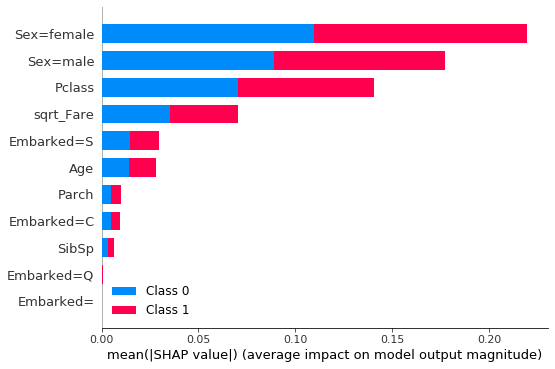

In [27]:
shap.summary_plot(shap_values, prepared_test)